In [13]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
import scipy.stats as st

print(np.random.rand(25))


[0.6915861  0.35166408 0.98617555 0.80253886 0.4538981  0.54687494
 0.06371643 0.18449728 0.27760722 0.34502707 0.51520694 0.83418241
 0.79699627 0.40361426 0.02963242 0.55798834 0.80853357 0.95243176
 0.40875391 0.79914163 0.13940462 0.89267473 0.65556098 0.78436222
 0.55681628]


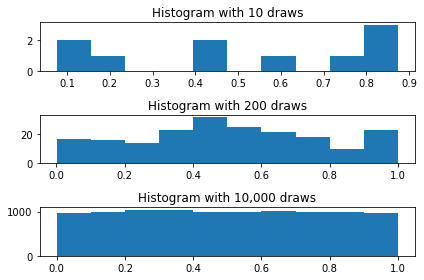

In [14]:
# Draw various numbers of uniform[0, 1] random variables
draws_10 = np.random.rand(10)
draws_200 = np.random.rand(200)
draws_10000 = np.random.rand(10_000)

# Plot their histograms
fig, ax = plt.subplots(3)

ax[0].set_title("Histogram with 10 draws")
ax[0].hist(draws_10)

ax[1].set_title("Histogram with 200 draws")
ax[1].hist(draws_200)

ax[2].set_title("Histogram with 10,000 draws")
ax[2].hist(draws_10000)

fig.tight_layout()

In [15]:
print(np.zeros((10,5) ))

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [16]:
# You'll see why we call it `_slow` soon :)
def simulate_loan_repayments_slow(N, r=0.05, repayment_full=25_000.0,
                                  repayment_part=12_500.0):
    repayment_sims = np.zeros(N)
    for i in range(N):
        x = np.random.rand()  # Draw a random number

        # Full repayment 75% of time
        if x < 0.75:
            repaid = repayment_full
        elif x < 0.95:
            repaid = repayment_part
        else:
            repaid = 0.0

        repayment_sims[i] = (1 / (1 + r)) * repaid

    return repayment_sims


In [17]:
def simulate_loan_repayments(N, r=0.05, repayment_full=25_000.0,
                             repayment_part=12_500.0):
    """
    Simulate present value of N loans given values for discount rate and
    repayment values
    """
    random_numbers = np.random.rand(N)

    # start as 0 -- no repayment
    repayment_sims = np.zeros(N)

    # adjust for full and partial repayment
    partial = random_numbers <= 0.20
    repayment_sims[partial] = repayment_part

    full = ~partial & (random_numbers <= 0.95)
    repayment_sims[full] = repayment_full

    repayment_sims = (1 / (1 + r)) * repayment_sims

    return repayment_sims

def simulate_year_of_loans(N=250, K=1000):

    # Create array where we store the values
    avg_repayments = np.zeros(K)
    for year in range(K):

        repaid_year = 0.0
        n_loans = simulate_loan_repayments(N)
        avg_repayments[year] = n_loans.mean()

    return avg_repayments

loan_repayment_outcomes = simulate_year_of_loans(N=250)

# Think about why we use the 5th percentile of outcomes to
# compute when we are profitable 95% of time
lro_5 = np.percentile(loan_repayment_outcomes, 5)

print("The largest loan size such that we were profitable 95% of time is")
print(lro_5)

The largest loan size such that we were profitable 95% of time is
19521.428571428572


In [56]:
def simulate_loan_lifetime(monthly_payment):

    # Create arrays to store outputs
    payments = np.zeros(12)
    # Note: dtype 'U12' means a string with no more than 12 characters
    statuses = np.array(4*["repaying", "delinquency", "default"], dtype="U12")

    # Everyone is repaying during their first month
    payments[0] = monthly_payment
    statuses[0] = "repaying"

    for month in range(1, 12):
        rn = np.random.rand()

        if (statuses[month-1] == "repaying"):
            if rn < 0.85:
                payments[month] = monthly_payment
                statuses[month] = "repaying"
            elif rn < 0.95:
                payments[month] = 0.0
                statuses[month] = "delinquency"
            else:
                payments[month] = 0.0
                statuses[month] = "default"
        elif (statuses[month-1] == "delinquency"):
            if rn < 0.25:
                payments[month] = monthly_payment
                statuses[month] = "repaying"
            elif rn < 0.85:
                payments[month] = 0.0
                statuses[month] = "delinquency"
            else:
                payments[month] = 0.0
                statuses[month] = "default"
        else:  # Default -- Stays in default after it gets there
            payments[month] = 0.0
            statuses[month] = "default"

    return payments, statuses


In [60]:
# 1. State description
state_values = ["repaying", "delinquency", "default"]

# 2. Transition probabilities: encoded in a matrix (2d-array) where element [i, j]
# is the probability of moving from state i to state j
P = np.array([[0.85, 0.1, 0.05], [0.25, 0.6, 0.15], [0, 0, 1]])

# 3. Initial distribution: assume loans start in repayment
x0 = np.array([1, 0, 0])
mc = qe.markov.MarkovChain(P, state_values)
print(mc.simulate(12, init="repaying"))

x = x0
for t in range(10):
    print(f"At time {t} the distribution is {x}")
    x = mc.P.T @ x

print(mc.stationary_distributions)

['repaying' 'delinquency' 'repaying' 'repaying' 'repaying' 'repaying'
 'delinquency' 'delinquency' 'delinquency' 'default' 'default' 'default']
At time 0 the distribution is [1 0 0]
At time 1 the distribution is [0.85 0.1  0.05]
At time 2 the distribution is [0.7475 0.145  0.1075]
At time 3 the distribution is [0.671625 0.16175  0.166625]
At time 4 the distribution is [0.61131875 0.1642125  0.22446875]
At time 5 the distribution is [0.56067406 0.15965937 0.27966656]
At time 6 the distribution is [0.5164878  0.15186303 0.33164917]
At time 7 the distribution is [0.47698039 0.1427666  0.38025302]
At time 8 the distribution is [0.44112498 0.133358   0.42551703]
At time 9 the distribution is [0.40829573 0.1241273  0.46757697]
[[0. 0. 1.]]


In [25]:

def normal_mean():
    randomNums = np.zeros(10_000)
    for n in range(10_000):
        randomNums[n] = np.random.normal()
    return np.mean(randomNums)

simNumber = 100
simArr = np.zeros(simNumber)
for sim in range(simNumber):   
    simArr[sim] = normal_mean()

print(np.mean(simArr))


-0.002460672834924389


In [55]:

def variance():
    randomNums = np.zeros(10_000)
    for n in range(10_000):
        randomNums[n] = 0 - np.random.normal()
    return np.var(randomNums)

print(variance())

0.9727471808996725


In [204]:
alpha = 0.05
phi = 0.10

earnerIncome = 10
nonearnerIncome = 1

x0 = np.array([900_000, 100_000])
employmentDyanmics = np.array([[1-alpha, alpha],[phi, 1-phi]])


state_values = ['employed', 'unemployed']
P = np.array([[0.95, 0.05],[.10, 0.90]])
x0 = np.array([1, 0])

mc = qe.markov.MarkovChain(P, state_values)

print(mc.simulate(12, init='employed'))
x = x0
for t in range(30):
    x = mc.P.T @ x
print(x)

print(mc.simulate(1, init='unemployed'))

y = np.flip(x0)
for t in range(30):
    y = mc.P.T @ y
print(y)

['employed' 'unemployed' 'unemployed' 'unemployed' 'unemployed'
 'unemployed' 'unemployed' 'unemployed' 'unemployed' 'unemployed'
 'unemployed' 'unemployed']
[0.66921025 0.33078975]
['unemployed']
[0.66157949 0.33842051]
